### Problem I


#### Podpunkt a

Generator liniowy kongruentny (LCG - Linear Congruential Generator) - metoda generowania liczb pseudolosowych, polegająca na obliczaniu kolejnych liczb $x_1, x_2, \dots, x_n$ z zakresu od $0$ do $m-1$ na podstawie wzoru: <br>
$$x_{k} = a \cdot (x_{k-1} + c) \; mod \; m,$$ <br>
gdzie $x_1$ jest tzw. ziarnem, czyli początkową wartością, którą inicjujemy generator. Warto wspomnieć o dwóch cechach takiego generatora:
* jest deterministyczny - zainicjowany tym samym ziarnem, zwróci taki sam ciąg pseudolosowych liczb,
* jeżeli kolejna wygenerowana liczba powtarza się w ciągu liczb już wygenerowanych to generator wpada w cykl. <br><br>

Bardzo ważne w konstrukcji dobrego generatora liniowego (czyli takiego, który ma jak najdłuższy cykl) jest odpowiednie dobranie współczynników $m$, $a$ i $c$. <br>
W naszym przypadku domyślnie przyjmują one takie same wartości jak w generatorze DERIVE ($m=2^{32}$, $a=3141592653$, $c=1$)[[1](#bibliografia)].

In [1]:
def LCG(m = 2**32, a = 3141592653, c = 1, seed = 1829309827820):
    """
    Linear congruential generator.
    
    Args:
        m (int): the modulus
        a (int): the multiplier
        c (int): the increment
        seed (int): starting value
    
    Returns:
        Yields a sequence of pseudo-randomized numbers.   
    """
    x1 = seed
    while True:
        xk = (a * x1 + c) % (m)
        x1 = xk
        yield xk

Mamy więc już liniowy kongruentny generator liczb pesudolosowych. Teraz przy jego pomocy definiujemy funkcję, która będzie zwracać $n$ pseudolosowych liczb całkowitych z zadanego przedziału domkniętego $\left[a, b \right]$:

In [2]:
def rand_ints(n, a, b, m = 2**32):
    """
    Function that uses linear congruential generator to generate pseudo-randomized integers in given range.
    
    Args:
        n (int): number of integers to generate
        a (float or int): lower boundary of desired range
        b (float or int): upper boundary of desired range
        m (int): the modulus
    
    Returns:
        n-element list of integers in range [a, b]
    """
    data = []
    generator = LCG()  
    for i in range(n):
        observation = next(generator) / m 
        data.append(round(observation * (b - a) + a))
    return data

#### Podpunkty b i c

Skoro możemy już generować pseudolosowe liczby całkowite, pora na kolejny krok - próby losowe z rozkładu jednostajnego. Aby zapewnić losowość generatora, zamiast ustalać z góry wartość ziarna, ustawiamy ją jako obecny czas systemowy (wyrażony w sekundach) pomnożony przez $1000$ i zaokrąglony do części całkowitej. <br>
Testując nasz generator, będziemy operować na próbach losowych z rozkładu $\mathit{U}\left(\left(0, 1\right) \cup \left(2^{64}-1, 2^{64}\right)\right)$. Tu pojawia się pierwszy problem - w arytmetyce zmiennoprzecinkowej część bitów przeznaczona jest na zapisywanie cyfr, a pozostałe na to, w którym miejscu stawiamy przecinek. Dlatego w przypadku bardzo dużych liczb, zwykły pythonowy float będzie wypisywał przybliżoną do części całkowitej wartość - wszystkie bity zostaną zużyte na zapisanie cyfr, z których dana liczba się składa. Tu pomocny okazuje się moduł $\textbf{decimal}$, pozwalający wypisywać nawet bardzo duże liczby zmiennoprzecinkowe z wybraną dokładnością.

In [3]:
import numpy as np
import time
import decimal as d

W pierwszej kolejności definiujemy funkcję generującą próbę losową długości $n$ z rozkładu $\mathit{U}(a, b)$.

In [4]:
def rand_unifs(n, a, b, prec):
    """
    Function that uses linear congruential generator to draw samples from uniform distribution.
    
    Args:
        n (int): sample length
        a (float or int): lower boundary of the output interval
        b (float or int): upper boundary of the output interval
        prec (int): decimal precision
    
    Returns:
        sample of n variables from uniform distribution over the (a, b) interval
    """
    d.getcontext().prec = prec
    t = time.time() # losowe ziarno - wykorzystujemy aktualny czas systemowy
    seed = int(round(t * 1000, 0))
    data = []
    generator = LCG(seed = seed) 
    for i in range(n):
        observation = d.Decimal(b - a) * next(generator) / 2 ** 32 + a
        data.append(observation)
    return data

Teraz, na potrzeby zadania, implementujemy funkcję, która będzie zwracać próbkę zmiennych losowych z rozkładu $\mathit{U}\left(\left(0, 1\right) \cup \left(2^{64}-1, 2^{64}\right)\right)$ za pomocą następującego algorytmu: <br>
1. Losuj n razy liczbę całkowitą z przedziału [0, 1]
2. Jeśli wypada 0, generuj zmienne losowe z przedziału (0, 1); jeśli 1, generuj z przedziału $\left(2^{64}-1, 2^{64}\right)$; dla wygody generujemy w dwóch osobnych listach
3. Zwróć tuplę z otrzymanych list.

In [5]:
def unif_samples(n):
    """
    Function to draw samples from uniform distribution over intervals (0, 1) and (2**64-1, 2**64). 
    
    Args:
        n (int): sample length
        
    Returns:
        sample of n variables from uniform distribution over the (0, 1) and (2**64-1, 2**64) intervals 
    """
    us = rand_ints(n, 0, 1) 
    zeros = us.count(0)
    ones = us.count(1)
    urands1 = rand_unifs(zeros, 0, 1, 8) 
    urands2 = rand_unifs(ones, 2**64 - 1, 2**64, 28) 
    return urands1, urands2

#### Podpunkt d

Aby pokazać, że nasz program działa poprawnie, zwizualizujemy otrzymane dane za pomocą wykresów - porównamy dystrybuantę empiryczną wygenerowanej próby losowej z dystrybuantą teoretyczną rozkładu jednostajnego na zadanych przedziałach oraz sporządzimy wykres punktów $\left(X_{i}, X_{i+1}\right)$.

In [6]:
import matplotlib.pyplot as plt
import collections as cl
from scipy.stats import uniform
import decimal as d

In [7]:
plt.rcParams["figure.figsize"] = [10, 7] # ustalamy rozmiar wykresów, domyślne są mało czytelne

Na początek definiujemy funkcję, która będzie rysować dystrybuantę empiryczną próby losowej na zadanych przedziałach. Jako argumenty przyjmować będzie listy zmiennych losowych z obu przedziałów oraz kolor linii (domyślnie niebieski).

In [8]:
def drawdemp(rv, rv1, color = "blue"):
    """
    Function to plot empirical cdf.
    
    Args:
        rv (list): random variables sample
        rv1 (list): random variables sample
        color (string): linecolor
    
    Returns:
        Plot of empirical cdf
    """
    data = cl.Counter(rv)
    data1 = cl.Counter(rv1)
    s_data = cl.OrderedDict(sorted(data.items()))
    s_data1 = cl.OrderedDict(sorted(data1.items()))
    xs = list(s_data.keys())
    xs1 = list(s_data1.keys())
    n = len(rv)
    n1 = len(rv1)
    li = [i[1] / n for i in s_data.items()]
    li1 = [i[1] / n1 for i in s_data1.items()]
    data = np.zeros(len(li) + 1)
    data1 = np.zeros(len(li1) + 1)
    data[1:] = np.cumsum([li])
    data1[1:] = np.cumsum([li1])
    xs.append(xs[-1] + 2)
    xs1.append(xs1[-1] + 2)
    plt.hlines(0, xs[0] - 2, xs[0], color = color)
    plt.hlines(0.5, xs1[0] - 2, xs1[0], color = color)
    plt.step(xs, data/2, color = color)
    plt.step(xs1, data1/2 + 0.5, color = color, label="Dystrybuanta empiryczna")
    plt.xlim(0, max(rv1))

Mamy już zaimplementowaną funkcję rysującą dystrybuantę empiryczną, teoretycznie więc możemy już wyświetlić wykres. Tu jednak napotykamy kolejny poważny problem - przedziały $(0, 1)$ i $\left(2^{64}-1, 2^{64}\right)$ są od siebie zbyt oddalone, by móc przedstawić je na jednym wykresie. Możemy jednak w prosty sposób obejść tę przeszkodę - wystarczy przesunąć drugi przedział, np. o $18446744073709551610$ jednostek w lewo.

In [9]:
data = unif_samples(1000)
u1 = data[0]
u2 = [i - 18446744073709551610 for i in data[1]] # przesuwamy drugi przedział

Po takiej operacji możemy już bez problemu zwizualizować wygenerowane dane i porównać je z teoretyczną dystrybuantą rozkładu $\mathit{U}\left(\left(0, 1\right) \cup \left(2^{64}-1, 2^{64}\right)\right)$. Dla próby długości $1000$ prezentuje się to następująco:

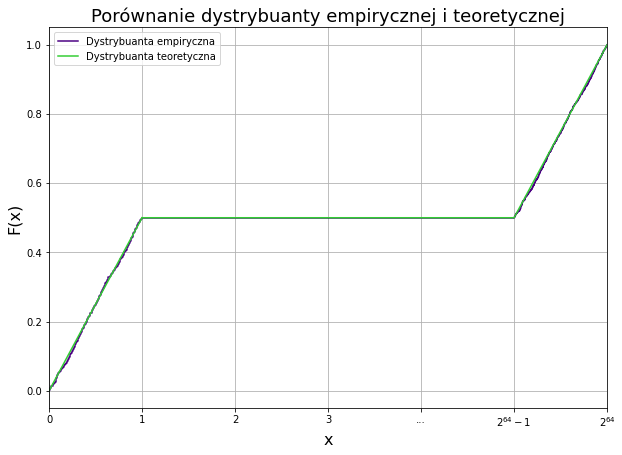

In [10]:
drawdemp(u1, u2, color="indigo")

p1 = np.linspace(0, 1, 1000)
p2 = np.linspace(1, 6, 5000)
plt.plot(p1, uniform.cdf(p1)/2, color="limegreen")
plt.plot(p2, uniform.cdf(p2, loc=5, scale=1)/2 + 0.5, color="limegreen", label="Dystrybuanta teoretyczna")

plt.xticks([0, 1, 2, 3, 4, 5, 6],[0, 1, 2, 3, "...", "$2^{64}-1$", "$2^{64}$"])
plt.title("Porównanie dystrybuanty empirycznej i teoretycznej", fontsize=18)
plt.xlabel("x", fontsize=16)
plt.ylabel("F(x)", fontsize=16)
plt.legend()
plt.grid()
pass

Widzimy, że otrzymane wykresy dobrze się pokrywają. Można stąd wnioskować, że nasz generator liczb losowych działa poprawnie. Jednak żeby lepiej zbadać jego działanie, dobrze nie poprzestawać tylko na jednym sposobie wizualizacji. Oprócz porównania dystrybuant, dobrą metodą testowania poprawności generatora jest sporządzenie wykresu punktów $\left(X_{i}, X_{i+1}\right)$.


In [11]:
data1 = unif_samples(10000) # tym razem próba długości 10000
p1 = data1[0]
p2 = [i - 18446744073709551610 for i in data[1]] # znów przesuwamy drugi przedział
points = p1 + p2

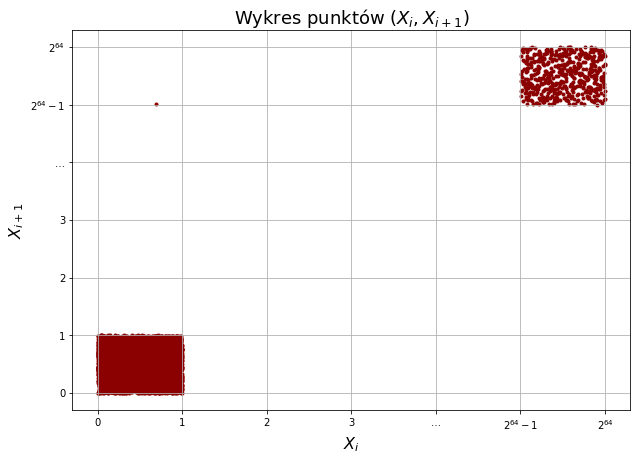

In [12]:
plt.scatter(np.array(points[:-1]), np.array(points[1:]), c="darkred", marker=".")
plt.title("Wykres punktów $(X_{i}, X_{i+1})$", fontsize=18)
plt.xlabel("$X_{i}$", fontsize=16)
plt.ylabel("$X_{i+1}$", fontsize=16)
plt.xticks([0, 1, 2, 3, 4, 5, 6],[0, 1, 2, 3, "$\dots$", "$2^{64}-1$", "$2^{64}$"])
plt.yticks([0, 1, 2, 3, 4, 5, 6],[0, 1, 2, 3, "$\dots$", "$2^{64}-1$", "$2^{64}$"])
plt.grid()
pass

Z powyższego wykresu widzimy, że zmienne losowe zwracane przez nasz generator zawierają się w odpowiednich przedziałach, zatem kolejny test wypada pozytywnie.

#### Podpunkt e

Oprócz graficznej wizualizacji danych, warto też przyjrzeć się statystykom liczbowym. Dwie podstawowe statystyki, które zbadamy w pierwszej kolejności, to średnia i wariancja próbkowa, wyrażone kolejno wzorami: <br><br>
$$\overline{X} = \frac{x_1 + x_2 + \dots + x_{n}}{n}$$ <br>
$$\sigma^2 = \frac{\left(x_1 - \overline{X}\right)^2 + \left(x_2 - \overline{X}\right)^2 + \dots + \left(x_{n} - \overline{X}\right)^2}{n}$$ <br>


In [13]:
import numpy as np
import decimal as d

In [14]:
d.getcontext().prec = 28

In [15]:
data2 = unif_samples(10000) # znów próba długości 10000
us1 = data2[0]
us2 = data2[1] 

In [16]:
alldata = us1 + us2
mean = d.Decimal(sum(alldata) / len(alldata))
var = d.Decimal(sum([(i - mean)**2 for i in alldata])  / len(alldata))
print(f"Średnia próbkowa: {mean}")
print(f"Wariancja próbkowa: {var}")

Średnia próbkowa: 9356188594185484579.627501061
Wariancja próbkowa: 8.505295149233343440661853857E+37


Otrzymane wyniki porównamy teraz ze średnią i wariancją próby tej samej długości, ale wygenerowanej za pomocą wbudowanego generatora $\textbf{random.uniform}$ z modułu $\textbf{numpy}$.

In [17]:
us3 = list(np.random.uniform(0, 1, size = len(us1)))
us3 = [d.Decimal(i) for i in us3]
us4 = np.random.uniform(0, 1, size = len(us2)) # nie można od razu wygenerować zmiennych z drugiego przedziału
us4 = [d.Decimal(2**64 - 1) + d.Decimal(i) for i in us4] # dlatego generujemy ponownie z przedziału (0, 1) i przesuwamy
alldata2 = us3 + us4

In [18]:
mean2 = d.Decimal(sum(alldata2) / len(alldata2))
var2 = d.Decimal(sum([(i - mean2)**2 for i in alldata2])  / len(alldata2))
print(f"Średnia próbkowa: {mean2}")
print(f"Wariancja próbkowa: {var2}")

Średnia próbkowa: 9356188594185484579.624382725
Wariancja próbkowa: 8.505295149233343440653864022E+37


Widzimy, że otrzymane na oba sposoby zarówno średnia, jak i wariancja, różnią się od siebie bardzo nieznacznie, zatem nasz generator przeszedł kolejny test.

Na koniec wykonamy test zgodności Kołmogorowa-Smirnowa, który pozwala sprawdzić, czy rozkład dla pewnej zmiennej losowej, różni się od założonego rozkładu teoretycznego, gdy znana jest jedynie pewna skończona liczba obserwacji tej zmiennej (próba statystyczna). [[2](#bibliografia)] Ogólnie przyjmuje się, że próba jest zgodna z założonym rozkładem, jeśli otrzymana w wyniku testu p-wartość jest większa niż $0.05$.

Test wykonamy za pomocą funkcji $\textbf{kstest}$ z biblioteki $\textbf{scipy.stats}$. 

In [19]:
from scipy.stats import kstest, uniform

Aby wykonać test, potrzebujemy prób losowych z obu przedziałów, przekonwertowanych na floaty. Wobec tego musimy znów przesunąć przedział $\left(2^{64}-1, 2^{64}\right)$ o $18446744073709551610$ jednostek w lewo - inaczej nie uzyskamy pożądanej dokładności.

In [20]:
data3 = unif_samples(10000) # próba długości 10000
ks1 = data3[0]
ks2 = [i - 18446744073709551610 for i in data3[1]] # przesuwamy drugi przedział

In [21]:
ks1 = [float(i) for i in ks1] # konwertujemy decimal na float
ks2 = [float(i) for i in ks2]

In [22]:
unif1 = lambda x: uniform.cdf(x)
unif2 = lambda x: uniform.cdf(x, loc=5, scale=1) # po przesunięciu mamy przedział (5, 6)

Mamy wygenerowane próby oraz dystrybuanty zdefiniowane na obu przedziałach, teraz testy zgodności:

In [23]:
print(f"KS-test for first interval: {kstest(ks1, unif1).pvalue > 0.05}")
print(f"KS-test for second interval: {kstest(ks2, unif2).pvalue > 0.05}")

KS-test for first interval: True
KS-test for second interval: True


Widzimy, że w obu przypadkach otrzymujemy p-wartość $> 0.05$, a zatem nasz generator pomyślnie przeszedł test zgodności Kołmogorowa-Smirnowa.

### Podsumowanie

Opracowany powyżej problem niósł ze sobą wiele trudności - największą z nich okazała się arytmetyka zmiennoprzecinkowa, która przy dostatecznie dużych liczbach traci konieczną tutaj precyzję. Wymagało to znalezienia sposobu na inną reprezentację liczb, w czym na szczęście Python, ze swoją mnogością modułów, okazał się niezawodny. 
Jednak badany rozkład przysporzył kłopotów nie tylko w tej jednej kwestii. Z racji tego, że oba przedziały, na których został zdefiniowany, są bardzo od siebie oddalone, problematyczna okazała się także wizualizacja generowanych danych. Naszym pomysłem na obejście tej przeszkody było przesunięcie przedziału tak, by dało się wszystkie dane umieścić na jednym wykresie. Co prawda jest to swego rodzaju oszustwo, jednak końcowy efekt zdaje się być zadowalający.<br><br>
Wszystkich napotkanych trudności oczywiście nie sposób spamiętać, a co dopiero rzetelnie omówić, dlatego poprzestaniemy na wyżej wymienionych.

### Źródła

<a id="bibliografia"></a>
[1] http://www.algorytm.org/liczby-pseudolosowe/generator-lcg-liniowy-generator-kongruentny.html <br>
[2] https://pl.wikipedia.org/wiki/Test_Ko%C5%82mogorowa-Smirnowa <br>